# Tutorial 7: Beyond Pandas - Third-Party Library Integration

<div class="alert alert-block alert-info"> <b>Before we get started: </b> 
    <ul style="list-style-type: none;margin: 0;padding: 0;">
        <li>✍️ To run this notebook, you need to have Ponder installed and set up on your machine. If you have not done so already, please refer to our <a href="https://docs.ponder.io/getting_started/quickstart.html">Quickstart guide</a> to get started.</li>
        <li>📖 Otherwise, if you're just interested in browsing through the tutorial, keep reading below!</li>
    </ul>
</div>

To support end-to-end data science workflows, Ponder supports integrations with other commonly used data science libraries in Python. In this tutorial, we will show examples of how you can work with other visualization and machine learning libraries in Python.

In [1]:
! pip install matplotlib scikit-learn xgboost --quiet

<div class="alert alert-block alert-info"> <b>Note: </b> While Ponder supports pandas and NumPy operations running on the data warehouse, we do not currently yet support other libraries to run the computation on the warehouse directly. Instead, Ponder pulls the data out of the warehouse and operates it in memory. If the table is exceeds 10k rows, we extract a sample of 10k rows to pull into memory. 
Here we use row_tranfer_limit in ponder.configure() to pull out all the rows in the dataset into memory. The third-party library operations will then be executed locally on this data and not in the warehouse.

The focus of this tutorial is to demonstrate how Ponder works well and interoperates with these library. <span>  </span></div>

 ## Visualization

Visualization is a critical part of any exploratory data analysis workflow for identifying patterns and trends in your data. Ponder works out of the box with popular plotting libraries in the PyData ecosystem, including sklearn and matplotlib. 

### matplotlib

In [2]:
import os; os.chdir("..")
import credential
import ponder; ponder.init()
import modin.pandas as pd
import snowflake.connector
snowflake_con = snowflake.connector.connect(user=credential.params["user"],password=credential.params["password"],account=credential.params["account"],role=credential.params["role"],database=credential.params["database"],schema=credential.params["schema"],warehouse=credential.params["warehouse"])
ponder.configure(default_connection=snowflake_con, row_transfer_limit=250_000)

2023-05-12 11:11:07 - Creating session lHtb8bF9jBqVBmkZLs7r1hBaZu7noXAwxHhikNUqPG


Here is an example of how to plot a histogram with Ponder:

In [3]:
df = pd.read_csv("https://github.com/ponder-org/ponder-datasets/blob/main/yellow_tripdata_2015-01.csv?raw=True", on_bad_lines='skip')

In [4]:
df.shape

(210035, 17)

In [5]:
df = pd.read_sql("PONDER_TAXI",con=snowflake_con)

<Axes: ylabel='Frequency'>

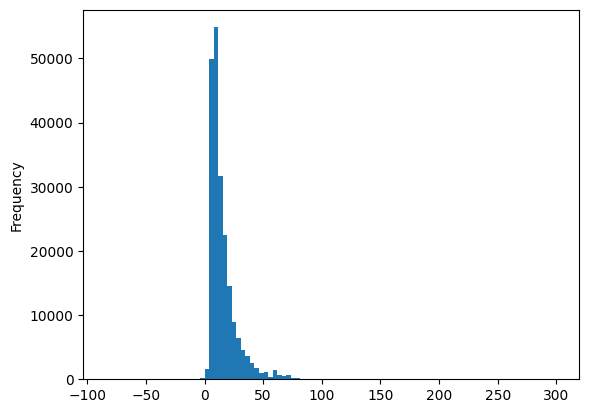

In [6]:
df["TOTAL_AMOUNT"].plot.hist(bins=100)

Here is an example of how to plot a scatterplot with Ponder:

<Axes: xlabel='MilesPerGal', ylabel='Horsepower'>

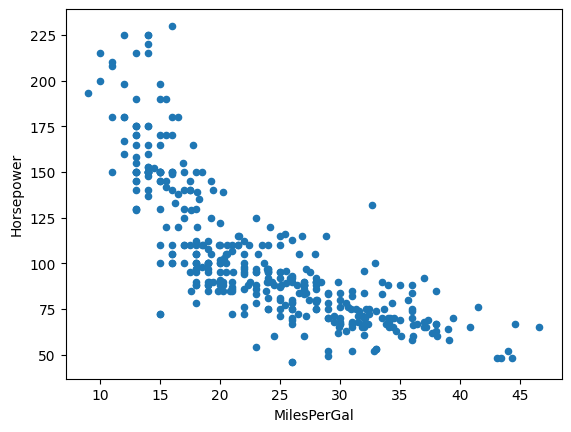

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/lux-org/lux-datasets/master/data/car.csv")
df.plot(x="MilesPerGal",y="Horsepower",kind="scatter")

You can also make more elaborate plots by making using of matplotlib's `plt.plot` functionality directly.

In [8]:
import matplotlib.pyplot as plt

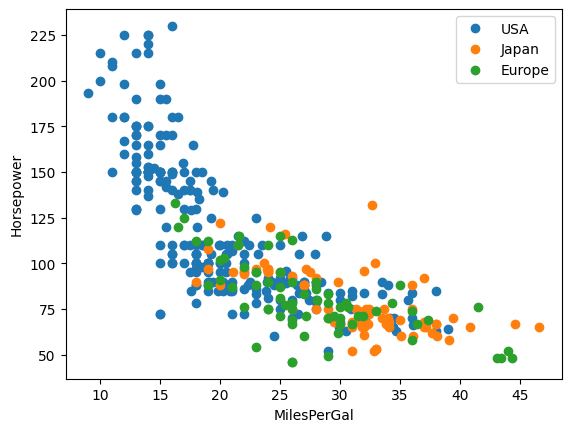

In [9]:
plt.xlabel("MilesPerGal")
plt.ylabel("Horsepower")
for country in df.Origin.unique(): 
    cdf = df[df["Origin"]==country]
    plt.plot(cdf["MilesPerGal"],cdf["Horsepower"],'o',label=country)
plt.legend()

### seaborn
Here is an example of how to plot a scatterplot with marginal distributions with Ponder and seaborn:

<Axes: xlabel='MilesPerGal', ylabel='Horsepower'>

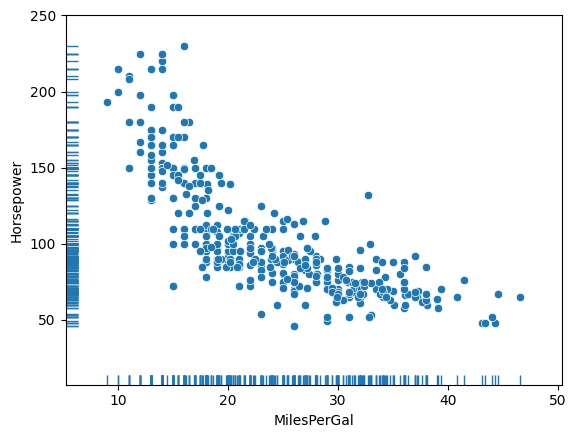

In [10]:
import seaborn as sns

df = pd.read_csv("https://raw.githubusercontent.com/lux-org/lux-datasets/master/data/car.csv")
sns.scatterplot(data=df, x="MilesPerGal",y="Horsepower")
sns.rugplot(data=df, x="MilesPerGal",y="Horsepower")

### plotly

Here is an example of how to plot a histogram with Ponder and plotly:

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

df = pd.read_csv("https://raw.githubusercontent.com/lux-org/lux-datasets/master/data/car.csv")
df = df[['MilesPerGal']]
fig = px.histogram(df, opacity=0.5, nbins=10)
fig.update_layout(xaxis_range=[0,60])
fig.update_xaxes(title_text='MilesPerGal')
fig.update_yaxes(title_text='No. of Cars')


### Machine Learning

Ponder integrates with popular libraries used for machine learning including sci-kit learn, XGBoost, HuggingFace, Tensorflow, and more. Ponder also provides the ability to run NumPy on your data warehouse directly, which is the foundation of machine learning training in Python.


#### Note: To use scikit-learn`train_test_split` on a dataset larger than 16k rows, you must set an environment variable `MASK_WITH_TEMP_TABLE` in your terminal:

In [12]:
df = pd.read_csv("https://github.com/ponder-org/ponder-datasets/blob/main/USA_Housing.csv?raw=True")

In [13]:
X = df.drop(columns=['PRICE', 'ADDRESS'])
y = df[['PRICE']]

#### Sci-kit Learn

The example here uses scikit-learn to predict housing prices. We replace missing values using SimpleImputer, train a LinearRegression model, and calculate the regression score.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)

my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [16]:
lr = LinearRegression()
lr.fit(train_X, train_y)
pred_y = lr.predict(test_X)

In [17]:
print(r2_score(pred_y,test_y)*100)

90.88941134530522


### XGBoost

Here we train an XGBoost regression model on the same housing data above and calculate metrics using scikit-learn mean_absolute_error.

In [18]:
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

/Users/labanyamukhopadhyay/opt/anaconda3/envs/ponder-local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [19]:
predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))
print(r2_score(predictions,test_y)*100)

Mean Absolute Error : 89924.73265144187
88.24670193063133


# Summary

In this tutorial, we learned how you can use popular Python libraries such as matplotlib, seaborn, sci-kit learn and XGBoost alongside Ponder.

In our [next tutorial](https://github.com/ponder-org/ponder-notebooks/blob/main/bigquery/tutorial/08-numpy.ipynb), we will demonstrate how you can use Ponder to run NumPy operations directly on your database.